## Final Model Hugging Face Link:
 https://huggingface.co/ishmamzarif/bangla_asr_augmented_bangla-whisper-epoch-11

## Table of Contents:
0. Hugging Face Login
1. Installing Dependencies and Seeding
2. Including Input Path, Model and Training Parameters
3. Loading and Augmenting Data
4. Preprocessing Dataset
5. Training Arguments
6. Training Model with Checkpoint Saving
7. Final Evaluation
8. Saving model Locally
9. Plotting Training Graphs  

In [1]:
!unzip -q shobdotori -d /content/

## 0. Hugging Face Login

In [ ]:
!pip install huggingface_hub transformers
from huggingface_hub import notebook_login

notebook_login()

## 1. Installing Dependencies and Seeding

In [2]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning,ignore::DeprecationWarning'

!pip uninstall -y transformers accelerate -q
!pip install -q transformers==4.44.2 accelerate==0.33.0
!pip install -q datasets==2.20.0 evaluate==0.4.1 jiwer==3.0.3
!pip install -q librosa==0.10.1 soundfile==0.12.1 tqdm
!pip install -q scikit-learn pandas
!pip install -q sentencepiece
!pip install -q fsspec==2025.3.0

print("\n" + "="*80)
print("All dependencies installed successfully!")
print("="*80)
print("   (Runtime → Restart runtime)")
print("="*80)

import sys
import torch
import transformers
import datasets
import librosa
import soundfile
import numpy as np
print("="*60)
print("ENVIRONMENT VERIFICATION")
print("="*60)
print("\n" + "="*60)
print("CUDA INFO")
print("="*60)
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
  print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print("="*60)



import random
import numpy as np
import torch
def set_seed(seed: int = 42):
  """Set seed for reproducibility across all libraries"""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    print(f"✓ Global seed set to {seed}")

set_seed(42)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.5.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.

All dependencies installed successfully!
   (Runtime → Restart runtime)
ENVIRONMENT VERIFICATION

CUDA INFO
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB
✓ Global seed set to 42


## 2. Including Input Path, Model and Training Parameters

In [8]:
import os
from pathlib import Path
class Config:
# Paths - UPDATE THESE IF YOUR DATA IS IN A DIFFERENT LOCATION
# USE KAGGLE PATH HERE ACCORDINGLY
  BASE_PATH = "/content/shobdotori"
  TRAIN_AUDIO_PATH = f"{BASE_PATH}/Train"
  TRAIN_ANNOTATION_PATH = f"{BASE_PATH}/Train_annotation"
  TEST_AUDIO_PATH = f"{BASE_PATH}/Test"
  OUTPUT_DIR = "./whisper-bangla-dialect"

  # Whisper Model
  MODEL_NAME = "bangla-speech-processing/BanglaASR"
  LANGUAGE = "bengali"
  TASK = "transcribe"

  # Training parameters - OPTIMIZED FOR >90% SIMILARITY
  BATCH_SIZE = 4
  GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch size = 16
  LEARNING_RATE = 3e-5  # Increased from 1e-5
  WARMUP_STEPS = 750  # Increased warmup
  NUM_TRAIN_EPOCHS = 12  # Increased from 8
  LOGGING_STEPS = 50

  # Audio processing
  SAMPLING_RATE = 16000
  MAX_AUDIO_LENGTH = 30  # seconds

  # Data Augmentation
  AUG_PROB = 0.5  # Apply augmentation 50% of the time
  FREQ_MASK_PARAM = 15
  TIME_MASK_PARAM = 35

In [4]:
print("Checking paths...")
print(f"Base path exists: {os.path.exists(Config.BASE_PATH)}")
print(f"Train audio exists: {os.path.exists(Config.TRAIN_AUDIO_PATH)}")
print(f"Train annotations exist: {os.path.exists(Config.TRAIN_ANNOTATION_PATH)}")
print(f"Test audio exists: {os.path.exists(Config.TEST_AUDIO_PATH)}")
if not os.path.exists(Config.TRAIN_AUDIO_PATH):
  print("\n WARNING: Update Config.BASE_PATH to match your Drive structure!")


Checking paths...
Base path exists: True
Train audio exists: True
Train annotations exist: True
Test audio exists: True


## 3. Loading and Augmenting Data

In [5]:
import torch
import numpy as np
class CustomSpecAugment:
  """
  SpecAugment for audio data augmentation
  Applies frequency and time masking to mel spectrograms
  """
  def __init__(self, freq_mask_param=15, time_mask_param=35):
    self.freq_mask_param = freq_mask_param
    self.time_mask_param = time_mask_param

  def freq_mask(self, spec, num_masks=1):
      """Apply frequency masking"""
      cloned = spec.copy()
      num_mel_channels = cloned.shape[0]

      for _ in range(num_masks):
          f = np.random.randint(0, self.freq_mask_param)
          f_zero = np.random.randint(0, num_mel_channels - f)
          cloned[f_zero:f_zero + f, :] = 0

      return cloned

  def time_mask(self, spec, num_masks=1):
      """Apply time masking"""
      cloned = spec.copy()
      len_spectro = cloned.shape[1]

      for _ in range(num_masks):
          t = np.random.randint(0, self.time_mask_param)
          t_zero = np.random.randint(0, len_spectro - t)
          cloned[:, t_zero:t_zero + t] = 0

      return cloned

  def __call__(self, spec):
      """Apply SpecAugment to mel spectrogram"""
      spec = self.freq_mask(spec, num_masks=1)
      spec = self.time_mask(spec, num_masks=1)
      return spec

In [9]:
spec_augment = CustomSpecAugment(freq_mask_param=Config.FREQ_MASK_PARAM, time_mask_param=Config.TIME_MASK_PARAM)
print("Data augmentation initialized!")
print(f"  Frequency mask parameter: {Config.FREQ_MASK_PARAM}")
print(f"  Time mask parameter: {Config.TIME_MASK_PARAM}")
print(f"  Augmentation probability: {Config.AUG_PROB}")

Data augmentation initialized!
  Frequency mask parameter: 15
  Time mask parameter: 35
  Augmentation probability: 0.5


In [11]:
import pandas as pd
def load_training_data(train_audio_path, train_annotation_path):
  """Load and combine all regional dialect data"""
  all_data = []


  # Get all region folders
  region_folders = sorted([f for f in os.listdir(train_audio_path)
                          if os.path.isdir(os.path.join(train_audio_path, f))])

  print(f"Found {len(region_folders)} regional dialects")

  for region in region_folders:
      # Find corresponding CSV file (case-insensitive)
      csv_files = [f for f in os.listdir(train_annotation_path)
                  if region.lower() in f.lower() and f.endswith('.csv')]

      if not csv_files:
          print(f"Warning: No CSV found for region {region}")
          continue

      csv_path = os.path.join(train_annotation_path, csv_files[0])
      df = pd.read_csv(csv_path)

      # Add full audio paths
      audio_dir = os.path.join(train_audio_path, region)
      df['audio_path'] = df['audio'].apply(lambda x: os.path.join(audio_dir, x))
      df['region'] = region

      # Verify files exist
      before_count = len(df)
      df = df[df['audio_path'].apply(os.path.exists)]
      after_count = len(df)

      if before_count != after_count:
          print(f"{region}: {before_count - after_count} audio files not found")

      all_data.append(df)
      print(f"Loaded {len(df)} samples from {region}")

      # Combining all data
  combined_df = pd.concat(all_data, ignore_index=True)

  # Removing any rows with empty text
  combined_df = combined_df[combined_df['text'].notna() & (combined_df['text'].str.strip() != '')]

  print(f"\n{'='*60}")
  print(f"Total training samples: {len(combined_df)}")
  print(f"{'='*60}")

  return combined_df

In [12]:
print("Loading training data...\n")
train_df = load_training_data(Config.TRAIN_AUDIO_PATH, Config.TRAIN_ANNOTATION_PATH)
print("\nSample data:")
print(train_df[['audio', 'text', 'region']].head(3))

Loading training data...

Found 20 regional dialects
Loaded 39 samples from Barisal
Loaded 189 samples from Bhola
Loaded 114 samples from Bogura
Loaded 107 samples from Brahmanbaria
Loaded 401 samples from Chittagong
Loaded 53 samples from Comilla
Loaded 115 samples from Dhaka
Loaded 66 samples from Feni
Loaded 33 samples from Jessore
Loaded 270 samples from Jhenaidah
Loaded 21 samples from Khulna
Loaded 53 samples from Kushtia
Loaded 400 samples from Lakshmipur
Loaded 400 samples from Mymensingh
Loaded 108 samples from Natore
Loaded 61 samples from Noakhali
Loaded 166 samples from Pabna
Loaded 73 samples from Rajshahi
Loaded 357 samples from Rangpur
Loaded 324 samples from Sylhet

Total training samples: 3350

Sample data:
                  audio                             text   region
0  female_barisal_1.wav  আজ সকালে আমি বাজারে গিয়েছিলাম।  Barisal
1  female_barisal_3.wav            আকাশে আজ মেঘ জমে আছে।  Barisal
2  female_barisal_4.wav   আমি বন্ধুদের সাথে খেলা খেলেছি।  Barisal


In [14]:
from sklearn.model_selection import train_test_split
# Split into train and validation (90/10 split, stratified by region)
train_split, val_split = train_test_split(
                          train_df,
                          test_size=0.1,
                          random_state=42,
                          stratify=train_df['region']
                          )
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"\nValidation region distribution:")
print(val_split['region'].value_counts().sort_index())

Training samples: 3015
Validation samples: 335

Validation region distribution:
region
Barisal          4
Bhola           19
Bogura          11
Brahmanbaria    11
Chittagong      40
Comilla          5
Dhaka           12
Feni             7
Jessore          3
Jhenaidah       27
Khulna           2
Kushtia          5
Lakshmipur      40
Mymensingh      40
Natore          11
Noakhali         6
Pabna           17
Rajshahi         7
Rangpur         36
Sylhet          32
Name: count, dtype: int64


### Defining Checkpoint Saving Logic

In [15]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
print(f"Loading {Config.MODEL_NAME}...")

processor = WhisperProcessor.from_pretrained(
Config.MODEL_NAME,
language=Config.LANGUAGE,
task=Config.TASK
)

model = WhisperForConditionalGeneration.from_pretrained(Config.MODEL_NAME)

if model.config.pad_token_id is None:
  model.config.pad_token_id = processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
  print(f" Set pad_token_id to: {model.config.pad_token_id} (EOS token ID)")
elif processor.tokenizer.pad_token_id is None:
  processor.tokenizer.pad_token_id = model.config.pad_token_id
  print(f" Set processor.tokenizer.pad_token_id to: {processor.tokenizer.pad_token_id}")


forced_decoder_ids = processor.get_decoder_prompt_ids(
language=Config.LANGUAGE,
task=Config.TASK
)
model.config.forced_decoder_ids = forced_decoder_ids
model.config.suppress_tokens = None
model.config.use_cache = False

model.config.dropout = 0.1
model.config.attention_dropout = 0.1
print("Model and processor loaded successfully!")

def repo_name_for_epoch(base, epoch):
    return f"bangla_asr_augmented_{base}-epoch-{epoch}"

from transformers import TrainerCallback

class PushEachEpochCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        epoch = int(state.epoch)
        repo = repo_name_for_epoch("bangla-whisper", epoch)
        print(f"\n📤 [Epoch {epoch}] Pushing model to HF repo: {repo}\n")

        model = kwargs["model"]
        model.push_to_hub(repo)

        try:
            processor.push_to_hub(repo)
        except:
            pass

        try:
            tokenizer.push_to_hub(repo)
        except:
            pass

        return control

print(f"  Model parameters: {model.num_parameters() / 1e6:.1f}M")
print(f"  Language: {Config.LANGUAGE}")
print(f"  Task: {Config.TASK}")
print(f"  Dropout: 0.1")
print(f"  Attention dropout: 0.1")



Loading bangla-speech-processing/BanglaASR...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model and processor loaded successfully!
  Model parameters: 241.7M
  Language: bengali
  Task: transcribe
  Dropout: 0.1
  Attention dropout: 0.1


In [16]:
from datasets import Dataset, Audio
import gc
def create_dataset(df, sampling_rate=16000):
  """Create HuggingFace Dataset with Audio feature"""
  dataset_dict = {
  'audio': df['audio_path'].tolist(),
  'text': df['text'].tolist(),
  'region': df['region'].tolist()
  }

  dataset = Dataset.from_dict(dataset_dict)

  dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate, mono=True))

  return dataset

print("Creating datasets with Audio feature...")
train_dataset = create_dataset(train_split, Config.SAMPLING_RATE)
val_dataset = create_dataset(val_split, Config.SAMPLING_RATE)
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
gc.collect()

Creating datasets with Audio feature...
Train dataset: 3015 samples
Val dataset: 335 samples


10376

### Applying Augmentation

In [17]:
import random
apply_augmentation_flag = True
def prepare_dataset(batch):
  """Preprocess audio and text for Whisper training with optional augmentation"""
  audio = batch["audio"]
  audio_array = audio["array"]

  max_samples = Config.MAX_AUDIO_LENGTH * Config.SAMPLING_RATE
  if len(audio_array) > max_samples:
      audio_array = audio_array[:max_samples]

  input_features = processor.feature_extractor(
      audio_array,
      sampling_rate=audio["sampling_rate"]
  ).input_features[0]

  if apply_augmentation_flag and random.random() < Config.AUG_PROB:
      try:
          input_features = spec_augment(input_features)
      except Exception as e:
          pass

  batch["input_features"] = input_features

  batch["labels"] = processor.tokenizer(batch["text"]).input_ids

  return batch

print("Enhanced preprocessing function defined!")
print(f"  Augmentation enabled: {apply_augmentation_flag}")
print(f"  Augmentation probability: {Config.AUG_PROB}")

Enhanced preprocessing function defined!
  Augmentation enabled: True
  Augmentation probability: 0.5


## 4. Preprocessing Dataset

In [18]:
print("Preprocessing datasets...")
print("This will take several minutes. Please be patient.\n")

print("Processing training data (WITH augmentation)...")
apply_augmentation_flag = True
train_dataset = train_dataset.map(
prepare_dataset,
remove_columns=train_dataset.column_names,
desc="Processing training data",
num_proc=1,
)

gc.collect()
if torch.cuda.is_available():
  torch.cuda.empty_cache()

print("\nProcessing validation data (WITHOUT augmentation)...")
apply_augmentation_flag = False
val_dataset = val_dataset.map(
prepare_dataset,
remove_columns=val_dataset.column_names,
desc="Processing validation data",
num_proc=1,
)

gc.collect()
if torch.cuda.is_available():
  torch.cuda.empty_cache()
print(f"\nPreprocessing complete!")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")

Preprocessing datasets...
This will take several minutes. Please be patient.

Processing training data (WITH augmentation)...


Processing training data:   0%|          | 0/3015 [00:00<?, ? examples/s]


Processing validation data (WITHOUT augmentation)...


Processing validation data:   0%|          | 0/335 [00:00<?, ? examples/s]


Preprocessing complete!
  Train samples: 3015
  Val samples: 335


### Defining evaluation functions

In [24]:
import evaluate
import numpy as np
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

wer_metric = evaluate.load("wer")
normalizer = BasicTextNormalizer()
def compute_metrics(pred):
  """Compute WER and Normalized Levenshtein Similarity"""
  pred_ids = pred.predictions
  label_ids = pred.label_ids

  # Handle tuple predictions
  if isinstance(pred_ids, tuple):
      pred_ids = pred_ids[0]

  # Replace -100 with pad_token_id
  label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

  # Decode predictions and labels
  pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

  # Normalize texts
  pred_str = [normalizer(text) for text in pred_str]
  label_str = [normalizer(text) for text in label_str]

  # Compute WER
  wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

  # Compute Normalized Levenshtein Similarity
  def levenshtein_distance(s1, s2):
      if len(s1) < len(s2):
          return levenshtein_distance(s2, s1)
      if len(s2) == 0:
          return len(s1)

      previous_row = range(len(s2) + 1)
      for i, c1 in enumerate(s1):
          current_row = [i + 1]
          for j, c2 in enumerate(s2):
              insertions = previous_row[j + 1] + 1
              deletions = current_row[j] + 1
              substitutions = previous_row[j] + (c1 != c2)
              current_row.append(min(insertions, deletions, substitutions))
          previous_row = current_row

      return previous_row[-1]

  similarities = []
  for pred, label in zip(pred_str, label_str):
      distance = levenshtein_distance(pred, label)
      max_len = max(len(pred), len(label))
      similarity = 100 * (1 - distance / max_len) if max_len > 0 else 100
      similarities.append(similarity)

  norm_levenshtein_sim = np.mean(similarities)

  return {
              "wer": wer,
              "norm_levenshtein_similarity": norm_levenshtein_sim
          }

print(" Evaluation metrics defined!")
print("  - Word Error Rate (WER)")
print("  - Normalized Levenshtein Similarity")

 Evaluation metrics defined!
  - Word Error Rate (WER)
  - Normalized Levenshtein Similarity


In [23]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
  """Custom data collator for Whisper training with dynamic padding"""
  processor: Any
  decoder_start_token_id: int

  def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
    # Split inputs and labels
    input_features = [{"input_features": feature["input_features"]} for feature in features]
    batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

    # Get labels
    label_features = [{"input_ids": feature["labels"]} for feature in features]
    labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

    # Replace padding with -100 to ignore loss correctly
    labels = labels_batch["input_ids"].masked_fill(
        labels_batch.attention_mask.ne(1), -100
    )

    # If bos token is appended in previous tokenization step,
    # cut bos token here as it's append later anyways
    if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
        labels = labels[:, 1:]

    batch["labels"] = labels

    # Explicitly create decoder_input_ids by shifting labels
    decoder_input_ids = labels.clone()
    decoder_input_ids[decoder_input_ids == -100] = self.processor.tokenizer.pad_token_id

    # Shift input_ids right
    shifted_decoder_input_ids = decoder_input_ids.new_zeros(decoder_input_ids.shape)
    shifted_decoder_input_ids[:, 1:] = decoder_input_ids[:, :-1].clone()
    shifted_decoder_input_ids[:, 0] = self.decoder_start_token_id

    batch["decoder_input_ids"] = shifted_decoder_input_ids

    return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
processor=processor,
decoder_start_token_id=model.config.decoder_start_token_id
)
print(" Data collator initialized!")

 Data collator initialized!


## 5. Training Arguments

In [22]:
from transformers import Seq2SeqTrainingArguments
# Clear memory before training
gc.collect()
if torch.cuda.is_available():
  torch.cuda.empty_cache()
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
use_fp16 = device == "cuda"
training_args = Seq2SeqTrainingArguments(
            output_dir=Config.OUTPUT_DIR,
            per_device_train_batch_size=Config.BATCH_SIZE,
            per_device_eval_batch_size=Config.BATCH_SIZE,
            gradient_accumulation_steps=Config.GRADIENT_ACCUMULATION_STEPS,
            learning_rate=Config.LEARNING_RATE,
            warmup_steps=Config.WARMUP_STEPS,
            num_train_epochs=Config.NUM_TRAIN_EPOCHS,
            gradient_checkpointing=True,
            fp16=use_fp16,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_steps=Config.LOGGING_STEPS,
            report_to=["tensorboard"],
            load_best_model_at_end=True,
            metric_for_best_model="norm_levenshtein_similarity",
            greater_is_better=True,
            predict_with_generate=True,
            generation_max_length=225,
            save_total_limit=3,  # Keep more checkpoints
            dataloader_num_workers=0,
            seed=42,
            # OPTIMIZED parameters for >90% similarity
            lr_scheduler_type="linear",
            weight_decay=0.005,
            label_smoothing_factor=0.05,
            max_grad_norm=0.5,
            warmup_ratio=0.1,
            )
print(" Optimized training arguments configured!")
print(f"  Device: {device}")
print(f"  Epochs: {Config.NUM_TRAIN_EPOCHS}")
print(f"  Batch size per device: {Config.BATCH_SIZE}")
print(f"  Gradient accumulation: {Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Effective batch size: {Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"  Learning rate: {Config.LEARNING_RATE}")
print(f"  Warmup steps: {Config.WARMUP_STEPS}")
print(f"  LR scheduler: linear")
print(f"  Weight decay: 0.005")
print(f"  Label smoothing: 0.05")
print(f"  Max grad norm: 0.5")
print(f"  FP16 training: {use_fp16}")


 Optimized training arguments configured!
  Device: cuda
  Epochs: 12
  Batch size per device: 4
  Gradient accumulation: 4
  Effective batch size: 16
  Learning rate: 3e-05
  Warmup steps: 750
  LR scheduler: linear
  Weight decay: 0.005
  Label smoothing: 0.05
  Max grad norm: 0.5
  FP16 training: True


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
from transformers import TrainerCallback
class DetailedMetricsCallback(TrainerCallback):
  """Callback to monitor detailed training metrics"""
  def __init__(self):
        super().__init__()
        self.best_similarity = 0.0

  def on_log(self, args, state, control, logs=None, **kwargs):
      if logs:
          if "loss" in logs:
              print(f"Step {state.global_step}: Loss = {logs['loss']:.4f}")
          if "learning_rate" in logs:
              print(f"  LR = {logs['learning_rate']:.2e}")

  def on_evaluate(self, args, state, control, metrics=None, **kwargs):
      if metrics and "eval_norm_levenshtein_similarity" in metrics:
          sim = metrics["eval_norm_levenshtein_similarity"]
          if sim > self.best_similarity:
              self.best_similarity = sim
              print(f"\n🎉 New best similarity: {sim:.2f}%")

In [30]:
metrics_callback = DetailedMetricsCallback()
print(" Custom metrics callback initialized!")

from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.tokenizer,
    callbacks=[
        metrics_callback,
        PushEachEpochCallback()
    ],
)
print(" Trainer initialized!")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Total training steps: {len(train_dataset) // (Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS) * Config.NUM_TRAIN_EPOCHS}")


 Custom metrics callback initialized!


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


 Trainer initialized!
  Training samples: 3015
  Validation samples: 335
  Total training steps: 2256


In [26]:
if not torch.cuda.is_available():
  print("="*80)
  print("WARNING: NO GPU DETECTED!")
  print("="*80)
  raise RuntimeError("GPU is required for training. Please enable GPU in runtime settings.")
else:
  print("="*80)
  print("GPU DETECTED - Ready for training!")
  print("="*80)
  print(f"GPU: {torch.cuda.get_device_name(0)}")
  print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
  print("="*80)

GPU DETECTED - Ready for training!
GPU: Tesla T4
Memory: 15.8 GB


In [27]:
import time
print("="*80)
print("Starting OPTIMIZED Whisper training...")
print("="*80)

start_time = time.time()

Starting OPTIMIZED Whisper training...


## 6. Training Model with Checkpoint Saving

In [ ]:
train_result = trainer.train()
end_time = time.time()
training_duration = end_time - start_time
print("\n" + "="*80)
print("✓ Whisper training completed!")
print(f"  Duration: {training_duration/3600:.2f} hours ({training_duration/60:.1f} minutes)")
print("="*80)

print("\nTraining metrics:")
for key, value in train_result.metrics.items():
  print(f"  {key}: {value}")

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Wer,Norm Levenshtein Similarity
0,1.079400,0.963404,39.897353,76.774691
2,0.816400,0.844433,23.716910,85.590027
4,0.777400,0.814212,17.504052,89.011984
6,0.756000,0.800245,16.072393,89.814135
8,0.746700,0.794167,12.884927,91.766032
10,0.742800,0.791846,11.696380,92.622563
11,0.742500,0.792748,11.939492,92.488058


Step 50: Loss = 2.3665
  LR = 1.96e-06
Step 100: Loss = 1.3168
  LR = 3.96e-06
Step 150: Loss = 1.0794
  LR = 5.96e-06

📤 [Epoch 0] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-0



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...uooa6rq/model.safetensors:   0%|          |  573kB /  967MB            

README.md: 0.00B [00:00, ?B/s]

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



🎉 New best similarity: 76.77%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 200: Loss = 0.9771
  LR = 7.96e-06
Step 250: Loss = 0.9044
  LR = 9.96e-06
Step 300: Loss = 0.8920
  LR = 1.20e-05
Step 350: Loss = 0.8759
  LR = 1.40e-05

📤 [Epoch 2] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-2



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._p5po_x/model.safetensors:   0%|          |  571kB /  967MB            

README.md: 0.00B [00:00, ?B/s]


🎉 New best similarity: 83.26%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 400: Loss = 0.8490
  LR = 1.60e-05
Step 450: Loss = 0.8232
  LR = 1.80e-05
Step 500: Loss = 0.8192
  LR = 2.00e-05
Step 550: Loss = 0.8164
  LR = 2.20e-05

📤 [Epoch 2] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-2



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...bypv49i/model.safetensors:   0%|          |  572kB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.



🎉 New best similarity: 85.59%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 600: Loss = 0.8022
  LR = 2.40e-05
Step 650: Loss = 0.7952
  LR = 2.60e-05
Step 700: Loss = 0.7952
  LR = 2.80e-05
Step 750: Loss = 0.7960
  LR = 3.00e-05

📤 [Epoch 4] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-4



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...dsve_xt/model.safetensors:   0%|          |  574kB /  967MB            

README.md: 0.00B [00:00, ?B/s]


🎉 New best similarity: 86.70%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 800: Loss = 0.7841
  LR = 2.90e-05
Step 850: Loss = 0.7869
  LR = 2.80e-05
Step 900: Loss = 0.7774
  LR = 2.70e-05

📤 [Epoch 4] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-4



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...fe9j7pg/model.safetensors:   0%|          |  573kB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.



🎉 New best similarity: 89.01%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 950: Loss = 0.7769
  LR = 2.60e-05
Step 1000: Loss = 0.7664
  LR = 2.50e-05
Step 1050: Loss = 0.7677
  LR = 2.40e-05
Step 1100: Loss = 0.7651
  LR = 2.30e-05

📤 [Epoch 6] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-6



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...1msgvy2/model.safetensors:   0%|          |  575kB /  967MB            

README.md: 0.00B [00:00, ?B/s]


🎉 New best similarity: 89.68%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 1150: Loss = 0.7623
  LR = 2.21e-05
Step 1200: Loss = 0.7588
  LR = 2.11e-05
Step 1250: Loss = 0.7564
  LR = 2.01e-05
Step 1300: Loss = 0.7560
  LR = 1.91e-05

📤 [Epoch 6] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-6



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...piyi0f_/model.safetensors:   0%|          |  574kB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.



🎉 New best similarity: 89.81%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 1350: Loss = 0.7546
  LR = 1.81e-05
Step 1400: Loss = 0.7512
  LR = 1.71e-05
Step 1450: Loss = 0.7510
  LR = 1.61e-05
Step 1500: Loss = 0.7500
  LR = 1.51e-05

📤 [Epoch 8] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-8



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...lny75l4/model.safetensors:   0%|          |  576kB /  967MB            

README.md: 0.00B [00:00, ?B/s]


🎉 New best similarity: 91.58%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 1550: Loss = 0.7484
  LR = 1.41e-05
Step 1600: Loss = 0.7469
  LR = 1.31e-05
Step 1650: Loss = 0.7467
  LR = 1.21e-05

📤 [Epoch 8] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-8



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...hup5__m/model.safetensors:   0%|          |  574kB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.



🎉 New best similarity: 91.77%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 1700: Loss = 0.7464
  LR = 1.11e-05
Step 1750: Loss = 0.7453
  LR = 1.01e-05
Step 1800: Loss = 0.7443
  LR = 9.10e-06
Step 1850: Loss = 0.7441
  LR = 8.11e-06

📤 [Epoch 10] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-10



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...64sxcl2/model.safetensors:   0%|          |  574kB /  967MB            

README.md: 0.00B [00:00, ?B/s]


🎉 New best similarity: 92.33%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 1900: Loss = 0.7439
  LR = 7.11e-06
Step 1950: Loss = 0.7431
  LR = 6.12e-06
Step 2000: Loss = 0.7429
  LR = 5.12e-06
Step 2050: Loss = 0.7428
  LR = 4.12e-06

📤 [Epoch 10] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-10



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...iegoixf/model.safetensors:   0%|          |  575kB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.



🎉 New best similarity: 92.62%


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step 2100: Loss = 0.7427
  LR = 3.13e-06
Step 2150: Loss = 0.7426
  LR = 2.13e-06
Step 2200: Loss = 0.7426
  LR = 1.14e-06
Step 2250: Loss = 0.7425
  LR = 1.39e-07


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}



📤 [Epoch 11] Pushing model to HF repo: bangla_asr_augmented_bangla-whisper-epoch-11



Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...qz2glhu/model.safetensors:   0%|          |  868kB /  967MB            

README.md: 0.00B [00:00, ?B/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].



✓ Whisper training completed!
  Duration: 4.14 hours (248.2 minutes)

Training metrics:
  train_runtime: 14890.1207
  train_samples_per_second: 2.43
  train_steps_per_second: 0.152
  total_flos: 1.04136041705472e+19
  train_loss: 0.8339431640949655
  epoch: 11.96816976127321


## 7. Final Evaluation

In [ ]:
print("Evaluating model on validation set...\n")
eval_results = trainer.evaluate()
print("Validation Results:")
print("="*60)
for key, value in eval_results.items():
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")
print("="*60)
final_wer = eval_results.get('eval_wer', 0.0)
final_similarity = eval_results.get('eval_norm_levenshtein_similarity', 0.0)
print(f"\n{'='*60}")
print(f"🎯 FINAL RESULTS")
print(f"{'='*60}")
print(f"✓ Final Validation WER: {final_wer:.2f}%")
print(f"✓ Final Normalized Levenshtein Similarity: {final_similarity:.2f}%")
if final_similarity >= 90.0:
  print(f"\n🎉 SUCCESS! Achieved target of >90% similarity!")
elif final_similarity >= 89.0:
  print(f"\n💪 Very close! Consider training for 2-3 more epochs.")
else:
  print(f"\n📊 Progress made. Current: {final_similarity:.2f}%, Previous: 89.44%")
  print(f"{'='*60}")

Evaluating model on validation set...



Validation Results:
  eval_loss: 0.7918
  eval_wer: 11.6964
  eval_norm_levenshtein_similarity: 92.6226
  eval_runtime: 217.1085
  eval_samples_per_second: 1.5430
  eval_steps_per_second: 0.3870
  epoch: 11.9682

🎯 FINAL RESULTS
✓ Final Validation WER: 11.70%
✓ Final Normalized Levenshtein Similarity: 92.62%

🎉 SUCCESS! Achieved target of >90% similarity!


## 8. Saving model Locally

In [ ]:
print("Saving final model...\n")
# Save model and processor
trainer.save_model(Config.OUTPUT_DIR)
processor.save_pretrained(Config.OUTPUT_DIR)
print(f"✓ Model saved to: {Config.OUTPUT_DIR}")
print(f"\nSaved files:")
for f in os.listdir(Config.OUTPUT_DIR):
  fpath = os.path.join(Config.OUTPUT_DIR, f)
  if os.path.isfile(fpath):
    size_mb = os.path.getsize(fpath) / (1024 * 1024)
    print(f"  {f}: {size_mb:.1f} MB")


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


Saving final model...

✓ Model saved to: ./whisper-bangla-dialect

Saved files:
  generation_config.json: 0.0 MB
  merges.txt: 0.5 MB
  normalizer.json: 0.1 MB
  added_tokens.json: 0.0 MB
  tokenizer_config.json: 0.0 MB
  preprocessor_config.json: 0.0 MB
  special_tokens_map.json: 0.0 MB
  config.json: 0.0 MB
  vocab.json: 1.0 MB
  training_args.bin: 0.0 MB
  model.safetensors: 922.2 MB


## 9. Plotting Training Graphs  

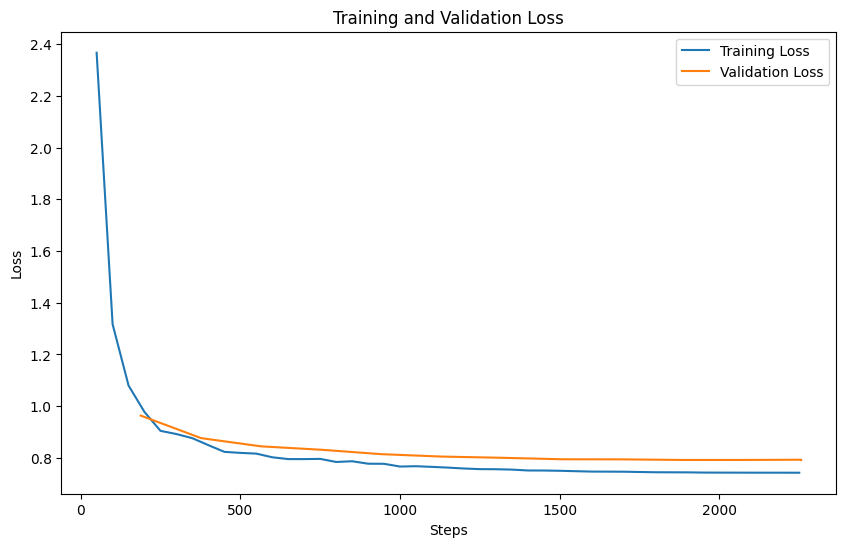

In [ ]:
import matplotlib.pyplot as plt

# Extract the training logs
logs = trainer.state.log_history

# Separate steps and loss values
train_loss_values = []
eval_loss_values = []
train_steps = []
eval_steps = []

for log in logs:
    if 'loss' in log:
        train_loss_values.append(log['loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_loss_values.append(log['eval_loss'])
        eval_steps.append(log['step'])

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label='Training Loss')
plt.plot(eval_steps, eval_loss_values, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()